# implicit regularisation through SGD

Why do neural networks rarely overfit? One possible explanation is that SGD _implicitly_ leads to regularisation. That is, among all minima of the loss function SGD picks one with small weight norm. And we know that regularisation inhibits overfitting.

## Load Fashion MNIST

In [1]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import zero_one_loss
plt.style.use("seaborn")

In [2]:
# fetch data from openml.org
# see https://www.openml.org/d/40996
fashion = fetch_openml('Fashion-MNIST', cache=True)
fashion.target = fashion.target.astype(np.int8) # fetch_openml() returns targets as strings
X, y = fashion["data"], fashion["target"]
X.shape

(70000, 784)

In [3]:
# images of data set have values in 0,...,255
# first scale all images to have values in [0,1] 
X=X/255
# we permute the data randomly
X, y = sklearn.utils.shuffle(X,y)

# Bad local minima

We perform three experiments, where we train a shallow neural network on the fashion data set, each time with different training sets. The training sets are made up as follows:

1. normal data set of 5000 images
2. the normal data set of 5000 images *plus* 5000 images with random labels
3. the normal data set of 5000 images *plus* 5000 other images with proper labels 

Each setting is repeated 10 times to gain a bit of statistical stability. Because it's simple I use here the neural network class of scikit-learn, MLPClassifier.

In [4]:
hidden=100

def analyse(X,y,train_size,corrupted_y,net):
    X_train,X_test=X[:train_size:],X[train_size:]
    y_train,y_test=y[:train_size],y[train_size:]
    corr_size=len(corrupted_y)
    corr_X_train=X[:corr_size]
    result={}
    result["iterations"]=net.n_iter_
    result["train err"]=zero_one_loss(y_train,net.predict(X_train))
    result["test err"]=zero_one_loss(y_test,net.predict(X_test))
    result["corr train err"]=zero_one_loss(corrupted_y,net.predict(corr_X_train))
    result["L2-norm"]=math.sqrt(np.linalg.norm(net.coefs_[0])**2+np.linalg.norm(net.coefs_[1])**2)
    result["L1-norm"]=np.linalg.norm(net.coefs_[0].flat,1)+np.linalg.norm(net.coefs_[1].flat,1)
    result["L2-norm bias"]=math.sqrt(np.linalg.norm(net.intercepts_[0])**2+np.linalg.norm(net.intercepts_[1])**2)
    result["L1-norm bias"]=np.linalg.norm(net.intercepts_[0].flat,1)+np.linalg.norm(net.intercepts_[1].flat,1)
    return result
    
def perform_passes(setup,X,y,train_size,corrupted_y,num_passes):
    res_list=[]
    corr_size=len(corrupted_y)
    corr_X_train=X[:corr_size]
    net=MLPClassifier(hidden_layer_sizes=hidden,max_iter=3000,alpha=0,\
                  solver='sgd',learning_rate='constant',learning_rate_init=0.01)
    for p in range(num_passes):
        net.fit(corr_X_train,corrupted_y)
        res=analyse(X,y,train_size,corrupted_y,net)
        res["setup"]=setup
        res_list.append(res)
    return res_list
        

We force SGD into other local minima by adding more data to the training set. For comparison we also compute a run of SGD without adding any data. The added data will have corrupt labels to force local minima that generalise badly. To achieve some statistical stability all tests are run five times. (More would be better but I didn't like to wait that long.)

In [5]:
train_size=5000
corruption_size=5000
num_passes=10 # how often we repeat each experiment to get statistically stable results

results=[]

## vanilla training, no corruption
results.extend(perform_passes("no corruption",X,y,train_size,y[:train_size],num_passes))

## training set + set with random labels
yy=np.array(y[:corruption_size])
np.random.shuffle(yy)
corrupted_y=np.hstack((y[:train_size],yy))
results.extend(perform_passes("random labels",X,y,train_size,corrupted_y,num_passes))

## train with real labels but training set of size train_size+corruption_size
large_size=train_size+corruption_size
results.extend(perform_passes("large",X,y,large_size,y[:large_size],num_passes))

F=pd.DataFrame(results)
F.to_csv("corruption.txt")
F

,iterations,train err,test err,corr train err,L2-norm,L1-norm,L2-norm bias,L1-norm bias,setup
0,575,0.0,0.163338,0.0000,25.575302,4880.257044,2.066592,16.758682,no corruption
1,523,0.0,0.163400,0.0000,25.193620,4837.514777,2.058899,16.626979,no corruption
2,531,0.0,0.163708,0.0000,25.199532,4862.033601,2.125582,17.056574,no corruption
3,522,0.0,0.164677,0.0000,25.229235,4846.440341,1.998544,15.824510,no corruption
4,515,0.0,0.163492,0.0000,25.126797,4825.836854,1.969107,15.860322,no corruption
5,550,0.0,0.163908,0.0000,25.372054,4841.849561,2.141500,17.089733,no corruption
6,585,0.0,0.163277,0.0000,25.616897,4910.291207,2.131746,16.320833,no corruption
7,592,0.0,0.163308,0.0000,25.704331,4900.182724,2.176662,16.873327,no corruption
8,538,0.0,0.163662,0.0000,25.202956,4820.626332,2.056383,15.854893,no corruption
9,517,0.0,0.163662,0.0000,25.180926,4840.389921,2.056107,16.146716,no corruption


In [6]:
# group by setup and take the mean
means=F.groupby("setup").mean()
means=means.sort_values(by=["L2-norm"])
means

,iterations,train err,test err,corr train err,L2-norm,L1-norm,L2-norm bias,L1-norm bias
setup,,,,,,,,
no corruption,544.8,0.0,0.163643,0.00000,25.340165,4856.542236,2.078112,16.441257
large,507.7,0.0,0.146267,0.00000,30.137422,5588.675385,2.371524,19.041298
random labels,954.4,0.0,0.547022,0.00002,64.947457,11647.409756,3.440800,28.710815


As expected adding corrupted data to the training set leads to local minima that generalise badly. Indeed, below the test error for the unadulterated is low ("no corruption", test error about 16.6%), while all aldulterated training sets lead to test errors above 50%. Note that in all these cases the error on the original training set is 0% or close to 0%. For comparision, the test error on a training set on 10000 samples is shown -- the same size as the aldulterated training sets. 

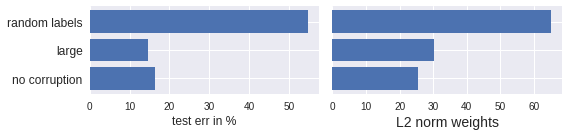

In [9]:
_,axs=plt.subplots(1,2,figsize=(8,2),sharey=True)
axs[0].barh(means.index,means["test err"]*100)
axs[0].set_xlabel("test err in %",fontsize=12)
axs[0].tick_params(axis='y', labelsize=12)

axs[1].barh(means.index,means["L2-norm"])
axs[1].set_xlabel("L2 norm weights",fontsize=14)

plt.tight_layout()
plt.savefig("rndlabels.png",dpi=300)
plt.show()

When plotting the L2 norms of the weight matrices we observe that SGD has an implicit regularising effect. Indeed, the local minimum reached by SGD for the unadulterated training set has significantly smaller L2 norm than the weights of the other minima. 